In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import tqdm

In [2]:
random_state = 42
n_bootstraped_samples = 1000

In [3]:
def map_rating_class(rating: float):
    return round(rating / 0.5) * 0.5

In [4]:
def align_dfs(true_df, pred_df):
    if true_df.shape != pred_df.shape:
        raise ValueError("The input dataframe have different dimensions")
    df = pd.merge(true_df, pred_df, on="RatingID")
    print(df.head())
    return df

In [5]:
def bootstrap_rmse(y_true, y_pred, n_bootstrap=n_bootstraped_samples, ci=95, random_state=random_state):
    rng = np.random.default_rng(random_state)
    rmse_score = []

    n = len(y_true)
    for _ in tqdm.tqdm(range(n_bootstrap)):
        indices = rng.choice(n, size=n, replace=True)
        sample_true = y_true[indices]
        sample_pred = y_pred[indices]
        
        rmse = root_mean_squared_error(sample_true, sample_pred)
        rmse_score.append(rmse)

    # Convert to numpy for easy math
    rmse_score = np.array(rmse_score)

    # Confidence interval
    lower = np.percentile(rmse_score, (100 - ci) / 2)
    upper = np.percentile(rmse_score, 100 - (100 - ci) / 2)

    return {
        'rmse_distribution': rmse_score,
        'mean': f"{rmse_score.mean():.4f}",
        'ci': f"[{lower:.4f}, {upper:.4f}]"
    }

In [6]:
# read all true y datasets
true_cold_user_cold_item = pd.read_csv(r"../../testset_cold_user_cold_item.csv")
true_cold_user_warm_item = pd.read_csv(r"../../testset_cold_user_warm_item.csv")
true_warm_user_cold_item = pd.read_csv(r"../../testset_warm_user_cold_item.csv")
true_warm_user_warm_item = pd.read_csv(r"../../testset_warm_user_warm_item.csv")

# only keep ReviewID, Rating
true_cold_user_cold_item = true_cold_user_cold_item[["RatingID", "Rating"]]
true_cold_user_warm_item = true_cold_user_warm_item[["RatingID", "Rating"]]
true_warm_user_cold_item = true_warm_user_cold_item[["RatingID", "Rating"]]
true_warm_user_warm_item = true_warm_user_warm_item[["RatingID", "Rating"]]


In [7]:
# read all predicted y datasets
vincent_cold_user_cold_item = pd.read_csv(r"./model_based_vincent/predictions_CU_CI.csv")
vincent_cold_user_warm_item = pd.read_csv(r"./model_based_vincent/predictions_CU_WI.csv")
vincent_warm_user_cold_item = pd.read_csv(r"./model_based_vincent/predictions_WU_CI.csv")
vincent_warm_user_warm_item = pd.read_csv(r"./model_based_vincent/predictions_WU_WI.csv")

# round ratings to closest .5 value
vincent_cold_user_cold_item["PredictedRating"] = vincent_cold_user_cold_item["PredictedRating"].map(lambda x: round(x / 0.5) * 0.5)
vincent_cold_user_warm_item["PredictedRating"] = vincent_cold_user_warm_item["PredictedRating"].map(lambda x: round(x / 0.5) * 0.5)
vincent_warm_user_cold_item["PredictedRating"] = vincent_warm_user_cold_item["PredictedRating"].map(lambda x: round(x / 0.5) * 0.5)
vincent_warm_user_warm_item["PredictedRating"] = vincent_warm_user_warm_item["PredictedRating"].map(lambda x: round(x / 0.5) * 0.5)

In [8]:
lightgbm_cold_user_cold_item = pd.read_csv(r"./lightgbm/lightgbm_cold_user_cold_item.csv")
lightgbm_cold_user_warm_item = pd.read_csv(r"./lightgbm/lightgbm_cold_user_warm_item.csv")
lightgbm_warm_user_cold_item = pd.read_csv(r"./lightgbm/lightgbm_warm_user_cold_item.csv")
lightgbm_warm_user_warm_item = pd.read_csv(r"./lightgbm/lightgbm_warm_user_warm_item.csv")

# round ratings to closest .5 value
lightgbm_cold_user_cold_item["Rating"] = lightgbm_cold_user_cold_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)
lightgbm_cold_user_warm_item["Rating"] = lightgbm_cold_user_warm_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)
lightgbm_warm_user_cold_item["Rating"] = lightgbm_warm_user_cold_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)
lightgbm_warm_user_warm_item["Rating"] = lightgbm_warm_user_warm_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)

In [9]:
svd_cold_user_cold_item = pd.read_csv(r"./svd/svd_cold_user_cold_item.csv")
svd_cold_user_warm_item = pd.read_csv(r"./svd/svd_cold_user_warm_item.csv")
svd_warm_user_cold_item = pd.read_csv(r"./svd/svd_warm_user_cold_item.csv")
svd_warm_user_warm_item = pd.read_csv(r"./svd/svd_warm_user_warm_item.csv")

# round ratings to closest .5 value
svd_cold_user_cold_item["Rating"] = svd_cold_user_cold_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)
svd_cold_user_warm_item["Rating"] = svd_cold_user_warm_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)
svd_warm_user_cold_item["Rating"] = svd_warm_user_cold_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)
svd_warm_user_warm_item["Rating"] = svd_warm_user_warm_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)

In [10]:
xgboost_cold_user_cold_item = pd.read_csv(r"./xgboost/xgboost_cold_user_cold_item.csv")
xgboost_cold_user_warm_item = pd.read_csv(r"./xgboost/xgboost_cold_user_warm_item.csv")
xgboost_warm_user_cold_item = pd.read_csv(r"./xgboost/xgboost_warm_user_cold_item.csv")
xgboost_warm_user_warm_item = pd.read_csv(r"./xgboost/xgboost_warm_user_warm_item.csv")

# round ratings to closest .5 value
xgboost_cold_user_cold_item["Rating"] = xgboost_cold_user_cold_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)
xgboost_cold_user_warm_item["Rating"] = xgboost_cold_user_warm_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)
xgboost_warm_user_cold_item["Rating"] = xgboost_warm_user_cold_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)
xgboost_warm_user_warm_item["Rating"] = xgboost_warm_user_warm_item["Rating"].map(lambda x: round(x / 0.5) * 0.5)

### Vincents Model-based Recommender System

#### Hot user, Hot Wine

In [11]:
aligned = align_dfs(true_warm_user_warm_item, vincent_warm_user_warm_item)
y_true = aligned['Rating'].values
y_pred = aligned['PredictedRating'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating  PredictedRating
0  17115002     4.5              4.0
1  17115008     3.0              4.0
2   8821172     4.0              4.0
3  15626850     4.0              3.5
4  15627422     4.0              4.5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  8.00it/s]

0.8077/[0.8053, 0.8100]


(array([  1.,   3.,  33.,  95., 224., 288., 216., 105.,  33.,   2.]),
 array([0.80276739, 0.80365708, 0.80454677, 0.80543647, 0.80632616,
        0.80721585, 0.80810555, 0.80899524, 0.80988493, 0.81077463,
        0.81166432]),
 <BarContainer object of 10 artists>)

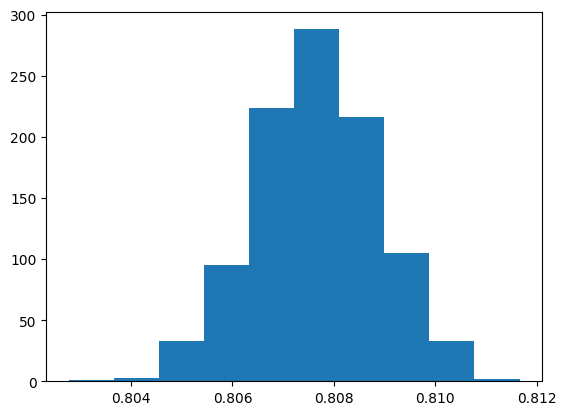

In [12]:
plt.hist(results["rmse_distribution"])

#### Hot user, Cold Wine

In [13]:
aligned = align_dfs(true_warm_user_cold_item, vincent_warm_user_cold_item)
y_true = aligned['Rating'].values
y_pred = aligned['PredictedRating'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating  PredictedRating
0  18311916     3.5              4.0
1  18303342     4.0              4.0
2  20547045     4.0              4.0
3  11900766     3.5              4.0
4  18273405     3.5              4.0


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1001.45it/s]

0.6982/[0.6908, 0.7060]


(array([ 13.,  34., 137., 214., 267., 188., 103.,  35.,   7.,   2.]),
 array([0.68678684, 0.68937951, 0.69197218, 0.69456485, 0.69715751,
        0.69975018, 0.70234285, 0.70493552, 0.70752819, 0.71012086,
        0.71271353]),
 <BarContainer object of 10 artists>)

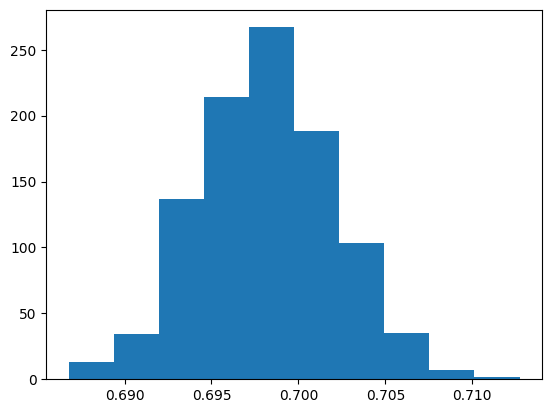

In [14]:
plt.hist(results["rmse_distribution"])

#### Cold user, Hot Wine

In [15]:
aligned = align_dfs(true_cold_user_warm_item, vincent_cold_user_warm_item)
y_true = aligned['Rating'].values
y_pred = aligned['PredictedRating'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating  PredictedRating
0  17618447     4.0              3.5
1  19286240     5.0              3.5
2  18939364     4.5              3.5
3  14312250     4.5              3.5
4  18967247     5.0              3.5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.83it/s]

1.0827/[1.0767, 1.0888]


(array([  8.,  39., 110., 208., 257., 233., 102.,  33.,   9.,   1.]),
 array([1.07341227, 1.07548371, 1.07755515, 1.0796266 , 1.08169804,
        1.08376949, 1.08584093, 1.08791238, 1.08998382, 1.09205527,
        1.09412671]),
 <BarContainer object of 10 artists>)

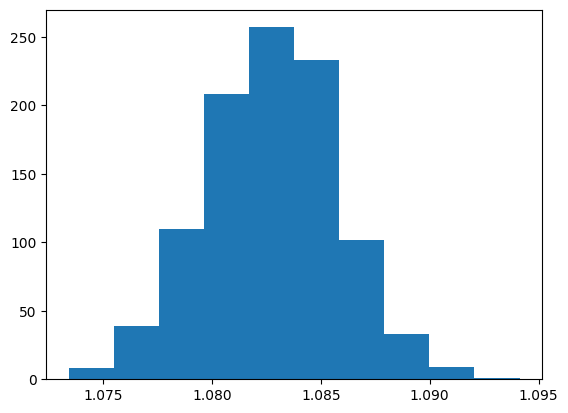

In [16]:
plt.hist(results["rmse_distribution"])

#### Cold user, Cold Wine

In [17]:
aligned = align_dfs(true_cold_user_cold_item, vincent_cold_user_cold_item)
y_true = aligned['Rating'].values
y_pred = aligned['PredictedRating'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating  PredictedRating
0  18274504     5.0              4.0
1  18317678     5.0              4.0
2  18317912     3.5              4.0
3  15708051     3.5              4.0
4   8822957     4.0              4.0


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1402.84it/s]

0.8645/[0.8528, 0.8765]


(array([ 11.,  70., 125., 240., 222., 191.,  93.,  36.,  11.,   1.]),
 array([0.84780912, 0.8516929 , 0.85557668, 0.85946046, 0.86334424,
        0.86722802, 0.8711118 , 0.87499558, 0.87887936, 0.88276314,
        0.88664692]),
 <BarContainer object of 10 artists>)

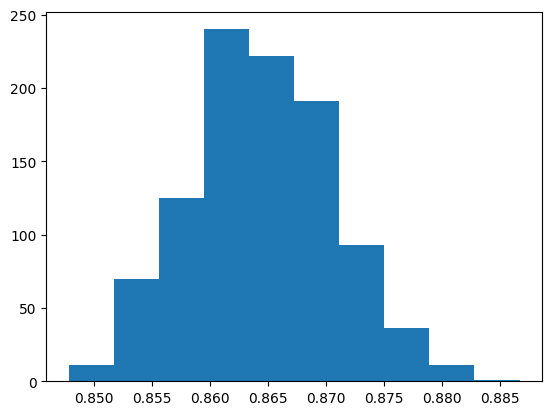

In [18]:
plt.hist(results["rmse_distribution"])

### Denis Model-based Recommender Systems

#### LightGBM

##### Hot user, Hot Wine

In [19]:
aligned = align_dfs(true_warm_user_warm_item, lightgbm_warm_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  17115002       4.5       4.5
1  17115008       3.0       3.5
2   8821172       4.0       4.0
3  15626850       4.0       4.0
4  15627422       4.0       4.0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:45<00:00,  9.48it/s]

0.6303/[0.6295, 0.6312]


(array([  9.,  56., 143., 221., 253., 183., 101.,  27.,   5.,   2.]),
 array([0.62902053, 0.62932834, 0.62963614, 0.62994394, 0.63025174,
        0.63055954, 0.63086734, 0.63117514, 0.63148295, 0.63179075,
        0.63209855]),
 <BarContainer object of 10 artists>)

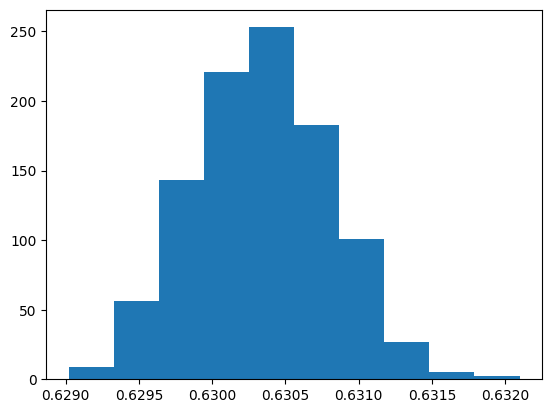

In [20]:
plt.hist(results["rmse_distribution"])

##### Hot user, Cold Wine

In [21]:
aligned = align_dfs(true_warm_user_cold_item, lightgbm_warm_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  18311916       3.5       3.5
1  18303342       4.0       4.0
2  20547045       4.0       4.0
3  11900766       3.5       4.0
4  18273405       3.5       4.0


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 733.39it/s]

0.6892/[0.6821, 0.6964]


(array([ 12.,  25., 111., 205., 282., 208., 116.,  28.,  10.,   3.]),
 array([0.67845107, 0.68082935, 0.68320762, 0.6855859 , 0.68796417,
        0.69034245, 0.69272072, 0.69509899, 0.69747727, 0.69985554,
        0.70223382]),
 <BarContainer object of 10 artists>)

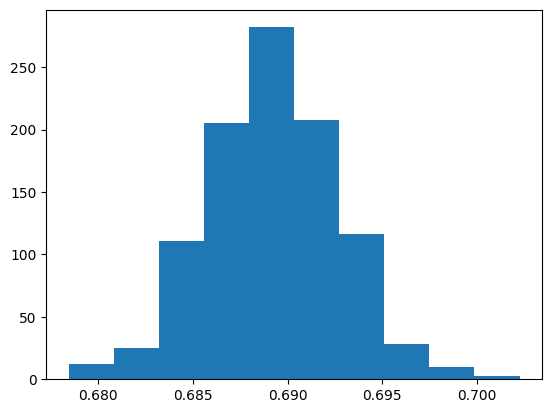

In [22]:
plt.hist(results["rmse_distribution"])

##### Cold user, Hot Wine

In [23]:
aligned = align_dfs(true_cold_user_warm_item, lightgbm_cold_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  17618447       4.0       4.0
1  19286240       5.0       3.5
2  18939364       4.5       4.0
3  14312250       4.5       3.5
4  18967247       5.0       4.0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.17it/s]

0.7063/[0.7044, 0.7081]


(array([  8.,  40., 104., 211., 275., 193., 121.,  37.,   8.,   3.]),
 array([0.70330149, 0.7039543 , 0.70460711, 0.70525992, 0.70591273,
        0.70656554, 0.70721834, 0.70787115, 0.70852396, 0.70917677,
        0.70982958]),
 <BarContainer object of 10 artists>)

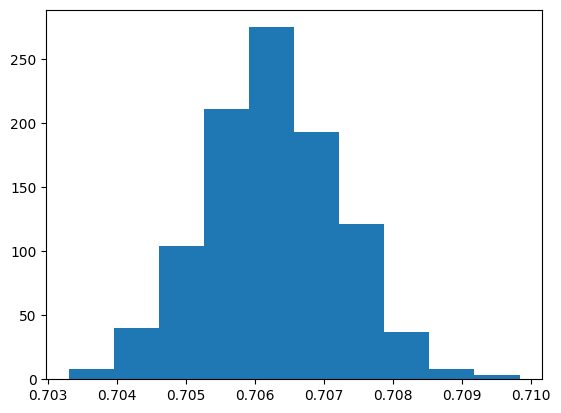

In [24]:
plt.hist(results["rmse_distribution"])

##### Cold user, Cold Wine

In [25]:
aligned = align_dfs(true_cold_user_cold_item, lightgbm_cold_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  18274504       5.0       4.0
1  18317678       5.0       3.5
2  18317912       3.5       3.5
3  15708051       3.5       4.0
4   8822957       4.0       3.5


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1418.38it/s]

0.7797/[0.7691, 0.7909]


(array([  7.,  38.,  85., 184., 244., 219., 133.,  58.,  27.,   5.]),
 array([0.7636403 , 0.76698676, 0.77033323, 0.77367969, 0.77702615,
        0.78037262, 0.78371908, 0.78706554, 0.79041201, 0.79375847,
        0.79710493]),
 <BarContainer object of 10 artists>)

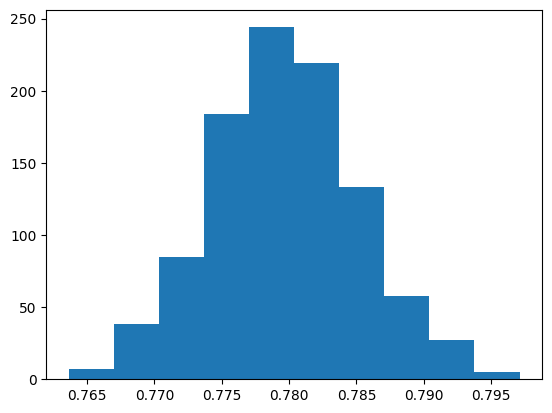

In [26]:
plt.hist(results["rmse_distribution"])

#### SVD

##### Hot user, Hot Wine

In [27]:
aligned = align_dfs(true_warm_user_warm_item, svd_warm_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  17115002       4.5       4.5
1  17115008       3.0       3.5
2   8821172       4.0       4.0
3  15626850       4.0       4.0
4  15627422       4.0       4.0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.80it/s]

0.5837/[0.5828, 0.5845]


(array([ 10.,  40., 114., 152., 209., 214., 145.,  81.,  27.,   8.]),
 array([0.58243699, 0.58269612, 0.58295525, 0.58321438, 0.58347351,
        0.58373264, 0.58399177, 0.58425089, 0.58451002, 0.58476915,
        0.58502828]),
 <BarContainer object of 10 artists>)

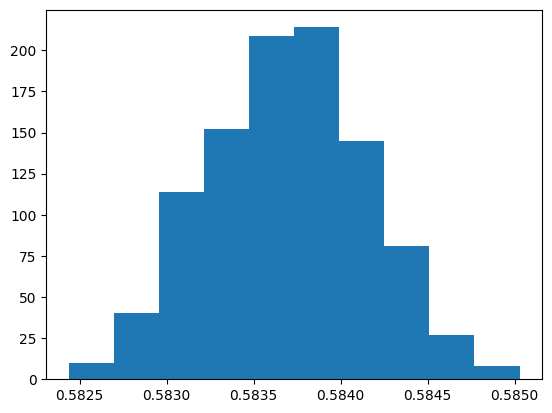

In [28]:
plt.hist(results["rmse_distribution"])

##### Hot user, Cold Wine

In [29]:
aligned = align_dfs(true_warm_user_cold_item, svd_warm_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  18311916       3.5       4.0
1  18303342       4.0       3.5
2  20547045       4.0       4.0
3  11900766       3.5       3.5
4  18273405       3.5       4.0


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 952.13it/s]

0.6606/[0.6534, 0.6674]


(array([ 11.,  44., 107., 190., 267., 206., 116.,  51.,   6.,   2.]),
 array([0.64982837, 0.65219622, 0.65456407, 0.65693192, 0.65929977,
        0.66166762, 0.66403548, 0.66640333, 0.66877118, 0.67113903,
        0.67350688]),
 <BarContainer object of 10 artists>)

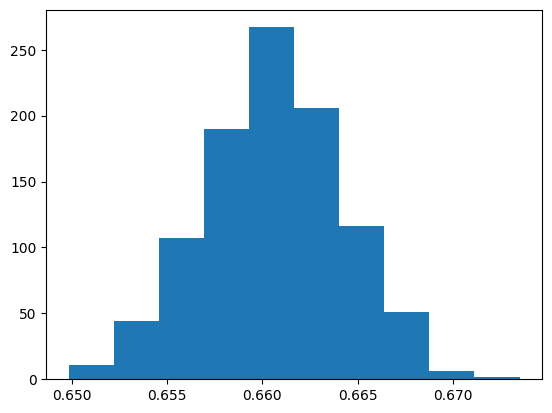

In [30]:
plt.hist(results["rmse_distribution"])

##### Cold user, Hot Wine

In [31]:
aligned = align_dfs(true_cold_user_warm_item, svd_cold_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  17618447       4.0       3.5
1  19286240       5.0       3.5
2  18939364       4.5       4.0
3  14312250       4.5       3.5
4  18967247       5.0       4.0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.69it/s]

0.6815/[0.6796, 0.6834]


(array([ 15.,  42., 111., 204., 268., 189., 128.,  33.,   6.,   4.]),
 array([0.67877209, 0.67938858, 0.68000508, 0.68062157, 0.68123806,
        0.68185455, 0.68247104, 0.68308754, 0.68370403, 0.68432052,
        0.68493701]),
 <BarContainer object of 10 artists>)

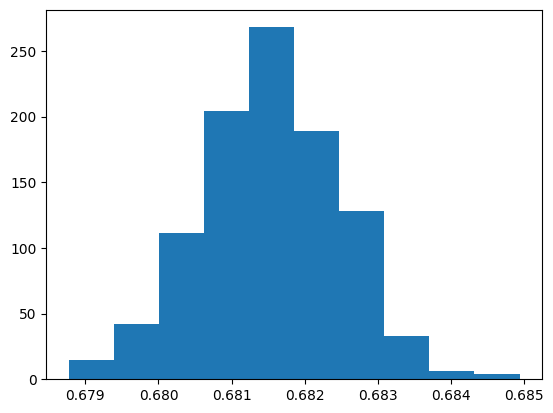

In [32]:
plt.hist(results["rmse_distribution"])

##### Cold user, Cold Wine

In [33]:
aligned = align_dfs(true_cold_user_cold_item, svd_cold_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  18274504       5.0       4.0
1  18317678       5.0       4.0
2  18317912       3.5       4.0
3  15708051       3.5       4.0
4   8822957       4.0       4.0


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1380.01it/s]

0.7896/[0.7789, 0.8016]


(array([ 15.,  44., 106., 184., 221., 193., 136.,  70.,  22.,   9.]),
 array([0.77399412, 0.7772939 , 0.78059369, 0.78389348, 0.78719326,
        0.79049305, 0.79379284, 0.79709262, 0.80039241, 0.8036922 ,
        0.80699199]),
 <BarContainer object of 10 artists>)

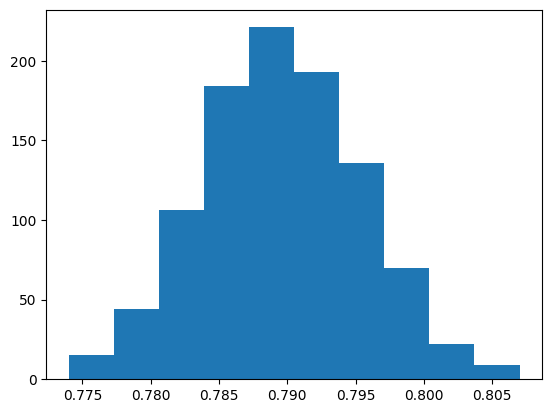

In [34]:
plt.hist(results["rmse_distribution"])

#### XGBoost

##### Hot user, Hot Wine

In [35]:
aligned = align_dfs(true_warm_user_warm_item, xgboost_warm_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  17115002       4.5       4.5
1  17115008       3.0       3.5
2   8821172       4.0       4.0
3  15626850       4.0       4.0
4  15627422       4.0       4.0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.40it/s]

0.6281/[0.6273, 0.6290]


(array([ 10.,  62., 141., 245., 262., 174.,  81.,  19.,   4.,   2.]),
 array([0.62683162, 0.62714507, 0.62745852, 0.62777197, 0.62808542,
        0.62839887, 0.62871232, 0.62902577, 0.62933922, 0.62965267,
        0.62996612]),
 <BarContainer object of 10 artists>)

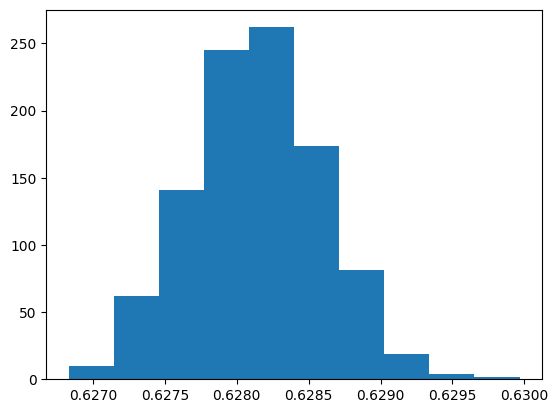

In [36]:
plt.hist(results["rmse_distribution"])

##### Hot user, Cold Wine

In [37]:
aligned = align_dfs(true_warm_user_cold_item, xgboost_warm_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  18311916       3.5       3.5
1  18303342       4.0       4.0
2  20547045       4.0       4.0
3  11900766       3.5       4.0
4  18273405       3.5       4.0


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 907.14it/s]

0.6790/[0.6721, 0.6864]


(array([ 14.,  33., 123., 210., 250., 199., 111.,  46.,  11.,   3.]),
 array([0.66859468, 0.67091666, 0.67323864, 0.67556062, 0.6778826 ,
        0.68020458, 0.68252656, 0.68484855, 0.68717053, 0.68949251,
        0.69181449]),
 <BarContainer object of 10 artists>)

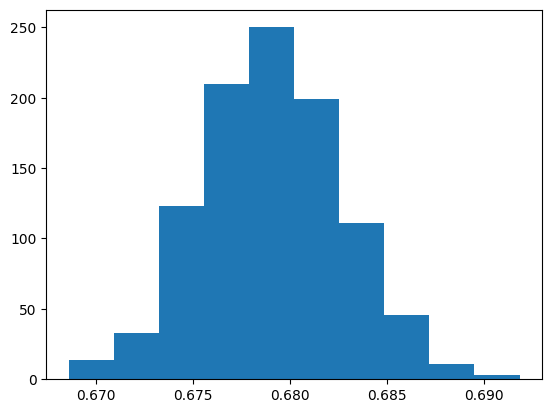

In [38]:
plt.hist(results["rmse_distribution"])

##### Cold user, Hot Wine

In [39]:
aligned = align_dfs(true_cold_user_warm_item, xgboost_cold_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  17618447       4.0       3.5
1  19286240       5.0       3.5
2  18939364       4.5       3.5
3  14312250       4.5       3.5
4  18967247       5.0       4.0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.19it/s]

0.7040/[0.7021, 0.7059]


(array([  7.,  29.,  99., 181., 263., 228., 123.,  55.,  12.,   3.]),
 array([0.70099152, 0.70164147, 0.70229143, 0.70294138, 0.70359134,
        0.70424129, 0.70489125, 0.7055412 , 0.70619116, 0.70684111,
        0.70749106]),
 <BarContainer object of 10 artists>)

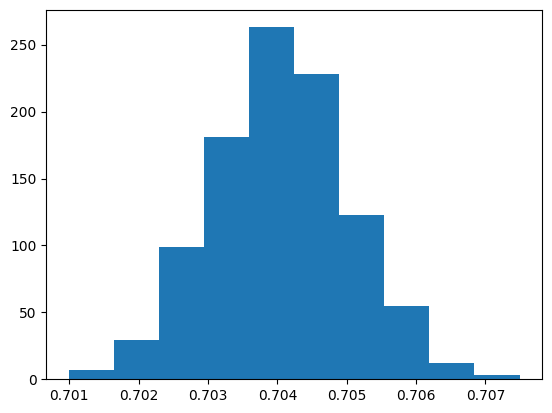

In [40]:
plt.hist(results["rmse_distribution"])

##### Cold user, Cold Wine

In [41]:
aligned = align_dfs(true_cold_user_cold_item, xgboost_cold_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

   RatingID  Rating_x  Rating_y
0  18274504       5.0       4.0
1  18317678       5.0       4.0
2  18317912       3.5       3.5
3  15708051       3.5       4.0
4   8822957       4.0       3.5


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1142.45it/s]

0.7807/[0.7699, 0.7918]


(array([  9.,  36.,  82., 169., 225., 226., 145.,  70.,  29.,   9.]),
 array([0.76454232, 0.76783468, 0.77112704, 0.7744194 , 0.77771176,
        0.78100412, 0.78429648, 0.78758884, 0.7908812 , 0.79417356,
        0.79746592]),
 <BarContainer object of 10 artists>)

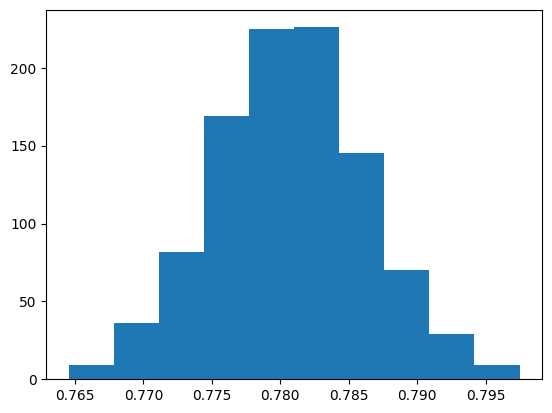

In [42]:
plt.hist(results["rmse_distribution"])

# Compare bootstraped sampled difference for best performing models

In [43]:
for _ in range(1000):
    idx = rng.choice(len(y_true), size=len(y_true), replace=True)
    rmse_a = root_mean_squared_error(y_true[idx], y_pred_a[idx])
    rmse_b = root_mean_squared_error(y_true[idx], y_pred_b[idx])
    diff = mae_b - mae_a  # Positive means A is better
    diff_scores.append(diff)


NameError: name 'rng' is not defined